# Geodemographics

- Contributors: Serge Rey (sjsrey@gmail.com)

This notebook demonstrates how to use GeoPyter to develop a session on [Geodemographics](https://www.mbaskool.com/business-concepts/marketing-and-strategy-terms/7264-geodemographics.html) while leveraging an atom on remote data processing to obtain a dataset for the subsequent analysis.

We begin by importing python modules we will require for the clustering analysis as part of our geodemographic work:

In [3]:
from sklearn.cluster import KMeans, AgglomerativeClustering

import matplotlib.pyplot as plt

import seaborn
%pylab inline
import matplotlib


Populating the interactive namespace from numpy and matplotlib


In [2]:
import matplotlib.rcsetup as rcsetup
print(rcsetup.all_backends)

['GTK3Agg', 'GTK3Cairo', 'MacOSX', 'nbAgg', 'Qt4Agg', 'Qt4Cairo', 'Qt5Agg', 'Qt5Cairo', 'TkAgg', 'TkCairo', 'WebAgg', 'WX', 'WXAgg', 'WXCairo', 'agg', 'cairo', 'pdf', 'pgf', 'ps', 'svg', 'template']


## Data Processing
Rather than having to find, extract, transform, and load [(ETL)](https://en.wikipedia.org/wiki/Extract,_transform,_load) a dataset for our analysis, we will make use of an existing [atom]() that does this for us. In the cell below we have syntax for geopyter that defines which atom we would like to import into our session. Once we do this, and the session is [compiled](), the cell that originally contained the syntax to define the atom we desire will be will be replaced with the contents of the atom.

@include {
    src = data/remote.ipynb
}

## Geodemographic Clustering
Having used an atom to produce our dataset, we first load it using geopandas:

In [9]:
pth = 'scag.shp' 

import geopandas

gdf = geopandas.read_file(pth)

gdf.columns

In [13]:
import pysal

/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/explore/segregation/network/network.py:16: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  "You need pandana and urbanaccess to work with segregation's network module\n"
/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [14]:
from pysal.lib.weights import Queen

In [15]:
w = Queen.from_dataframe(gdf)

/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/lib/weights/contiguity.py:185: UserWarning: There is one disconnected observation (no neighbors).
Island id: 5275
  W.__init__(self, neighbors, ids=ids, **kw)


In [16]:
w.islands # maybe drop this or show how to do so

[5275]

In [17]:
gdf.drop(w.islands, inplace=True)

In [18]:
w = Queen.from_dataframe(gdf)

/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)


In [19]:
cluster_variables = ['pop_den', 'HISP_pct',
                    'NHWHT_pct', 'NHBLK_pct',
                    'NHNATIVE_p', 'NHASIAN_pc']

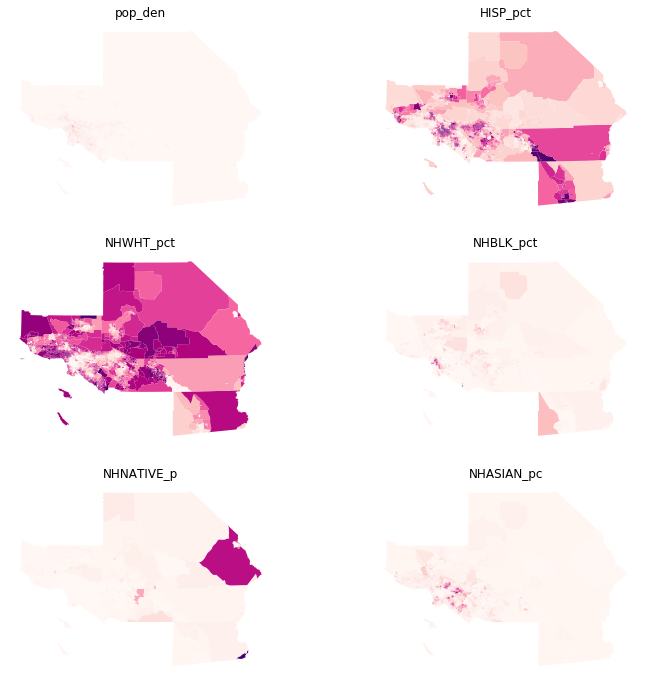

In [20]:
f, axs = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    #db.plot(column=col, ax=ax, scheme='Quantiles', 
    #        linewidth=0, cmap='RdPu')
    gdf.plot(col, cmap='RdPu', ax=ax)
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
plt.show()


In [21]:
from pysal.explore.esda import Moran
import numpy
import pandas
db = gdf

In [22]:
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(db[variable], w) for variable in cluster_variables]
# Display on table
table = pandas.DataFrame([(variable, res.I, res.p_sim) for variable,res 
                      in zip(cluster_variables, mi_results)],
                     columns=['Variable', "Moran's I", 'P-value'])\
          .set_index('Variable')
numpy.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [Moran(db[variable], w) for variable in cluster_variables]
# Display on table
table = pandas.DataFrame([(variable, res.I, res.p_sim) for variable,res 
                      in zip(cluster_variables, mi_results)],
                     columns=['Variable', "Moran's I", 'P-value'])\
          .set_index('Variable')
table

,Moran's I,P-value
Variable,,
pop_den,0.632033,0.001
HISP_pct,0.672525,0.001
NHWHT_pct,0.623227,0.001
NHBLK_pct,0.715526,0.001
NHNATIVE_p,0.131235,0.001
NHASIAN_pc,0.689818,0.001


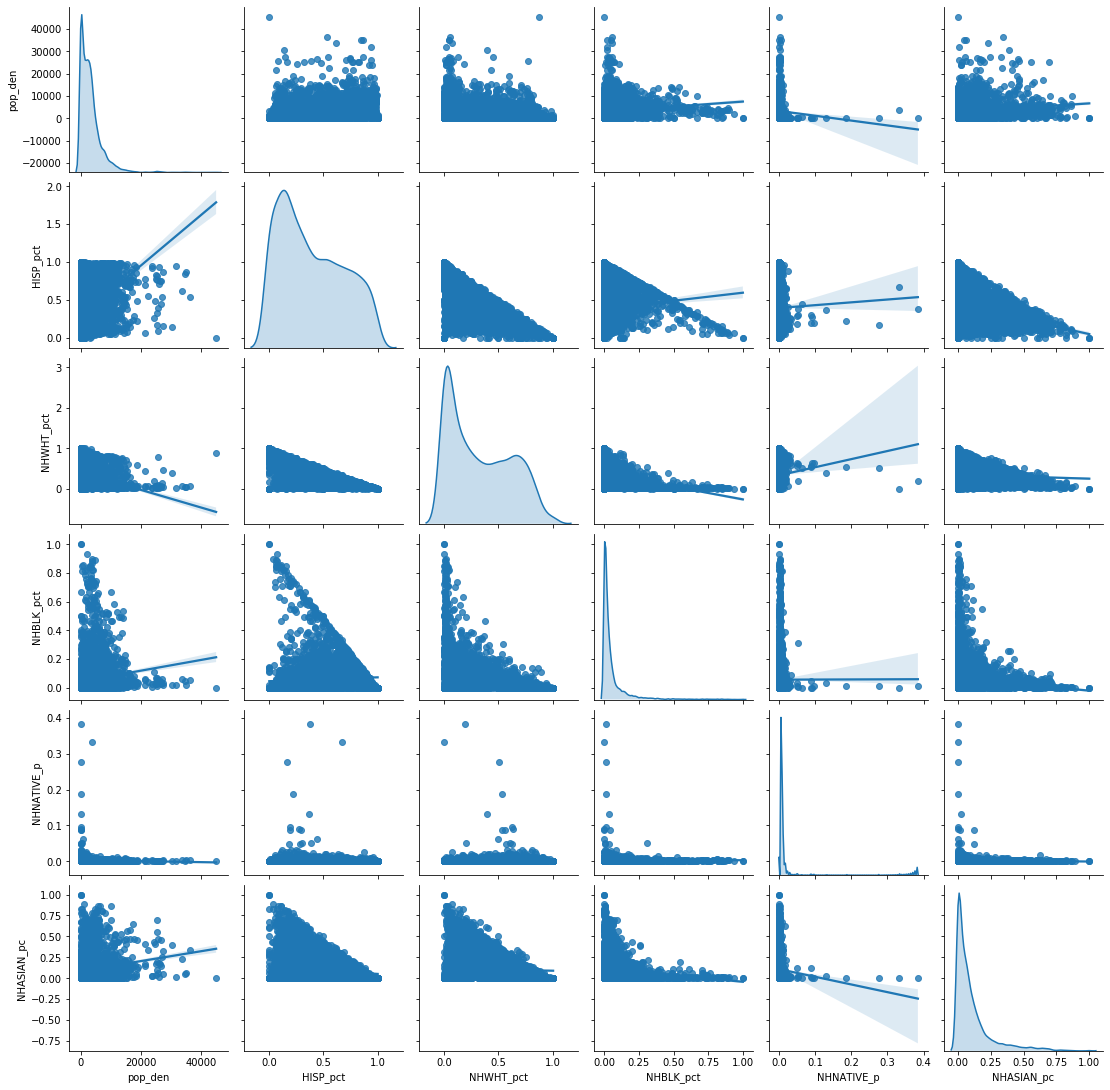

In [23]:
_ = seaborn.pairplot(db[cluster_variables], kind='reg', diag_kind='kde')


## Clustering

In [24]:
kmeans = KMeans(n_clusters=30)
numpy.random.seed(12345)
k30cls = kmeans.fit(gdf[cluster_variables])

In [25]:
k30cls.labels_

array([7, 1, 3, ..., 7, 7, 7], dtype=int32)

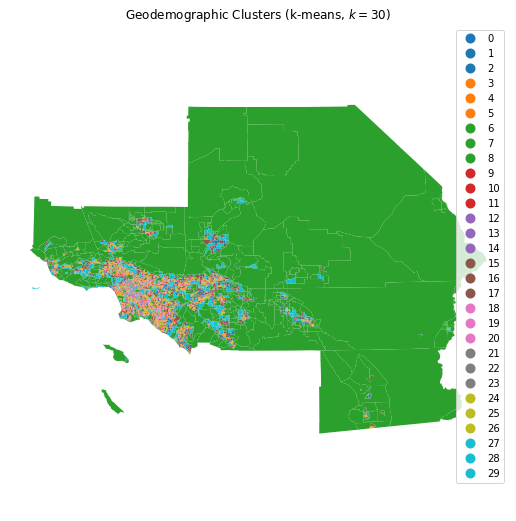

In [26]:
db['k30cls'] = k30cls.labels_
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='k30cls', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Clusters (k-means, $k=30$)')
# Display the map
plt.show()

In [27]:
k30sizes = db.groupby('k30cls').size()
k30sizes

k30cls
0     109
1     283
2      13
3     331
4     226
5       4
6      53
7     982
8      13
9     124
10     35
11    328
12      1
13    170
14     70
15    331
16    281
17     49
18    304
19      4
20    103
21      7
22     23
23     80
24    158
25    312
26    344
27    197
28      2
29    338
dtype: int64

In [28]:
k30means = db.groupby('k30cls')[cluster_variables].mean()
k30means

,pop_den,HISP_pct,NHWHT_pct,NHBLK_pct,NHNATIVE_p,NHASIAN_pc
k30cls,,,,,,
0,8242.209177,0.664312,0.138451,0.082573,0.001665,0.095751
1,1247.851873,0.298830,0.502501,0.045903,0.002983,0.121830
2,17948.850127,0.655394,0.092835,0.035926,0.001335,0.200611
3,2493.366509,0.389248,0.399699,0.065159,0.002536,0.114283
4,4347.416243,0.507806,0.250576,0.061859,0.002164,0.154398
5,35028.689390,0.713643,0.054623,0.045631,0.002459,0.171900
6,11180.021337,0.629200,0.140713,0.079485,0.001334,0.130417
7,29.824719,0.167499,0.308158,0.020390,0.003463,0.030318
8,25076.662218,0.591099,0.107385,0.042981,0.000987,0.244477


## Clustering by County

In [29]:
counties = pandas.unique(db['COUNTY'])

In [30]:
counties

array(['025', '037', '059', '065', '071', '111'], dtype=object)

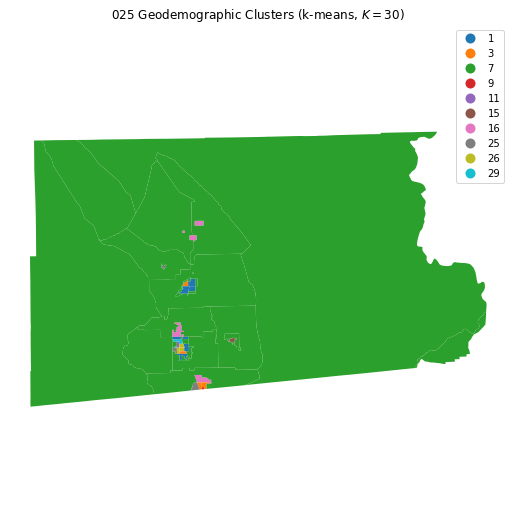

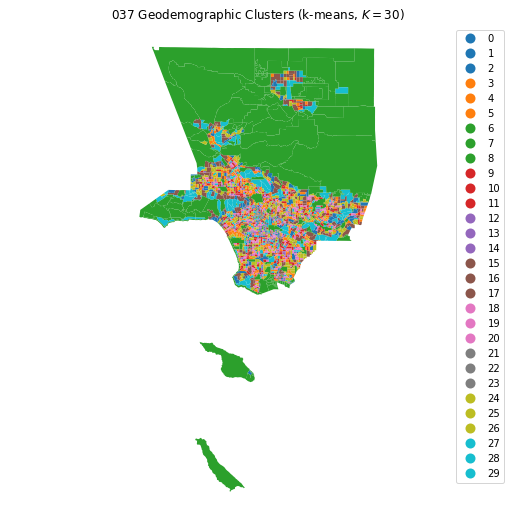

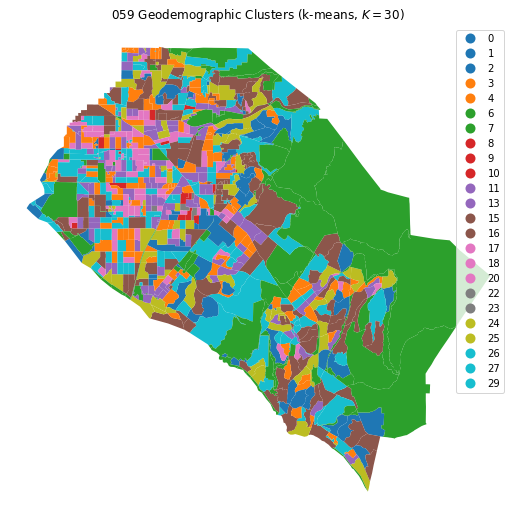

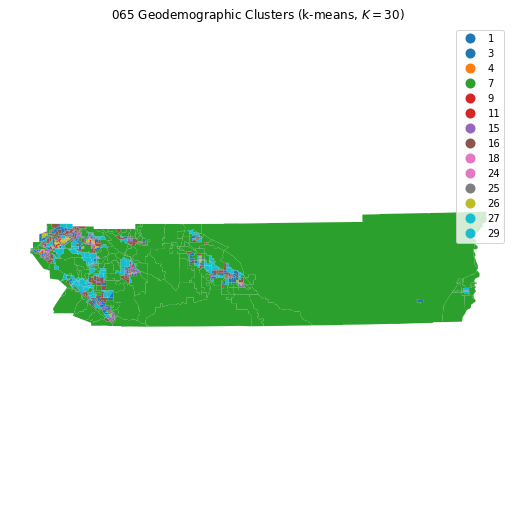

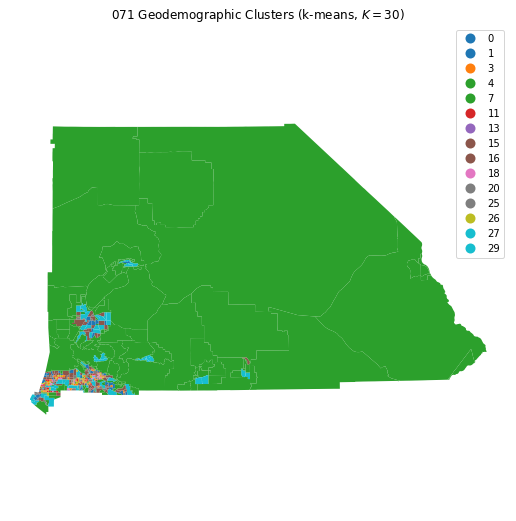

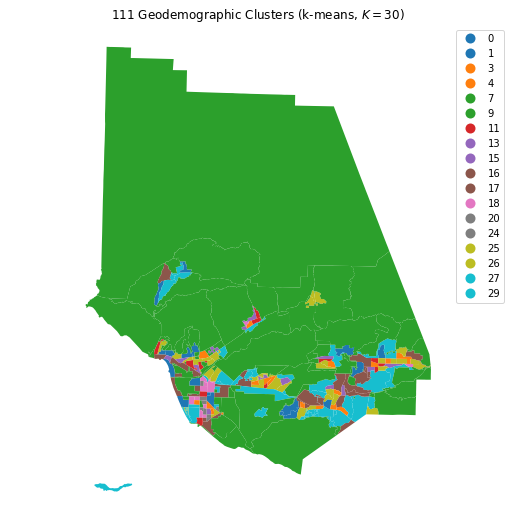

In [31]:
for county in counties:
    cdb = db[db['COUNTY']==county]
    f, ax = plt.subplots(1, figsize=(9, 9))
    # Plot unique values choropleth including a legend and with no boundary lines
    cdb.plot(column='k30cls', categorical=True, legend=True, linewidth=0, ax=ax)
    # Remove axis
    ax.set_axis_off()
    # Keep axes proportionate
    plt.axis('equal')
    # Add title
    title = f'{county} Geodemographic Clusters (k-means, $K=30$)'
    plt.title(title)
    # Display the map
plt.show()

## Spatial Clustering

In [32]:
numpy.random.seed(123456)
model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=30)
model.fit(db[cluster_variables])

/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<5275x5275 sparse matrix of type '<class 'numpy.float64'>'
	with 35066 stored elements in Compressed Sparse Row format>,
                        distance_threshold=None, linkage='ward', memory=None,
                        n_clusters=30)

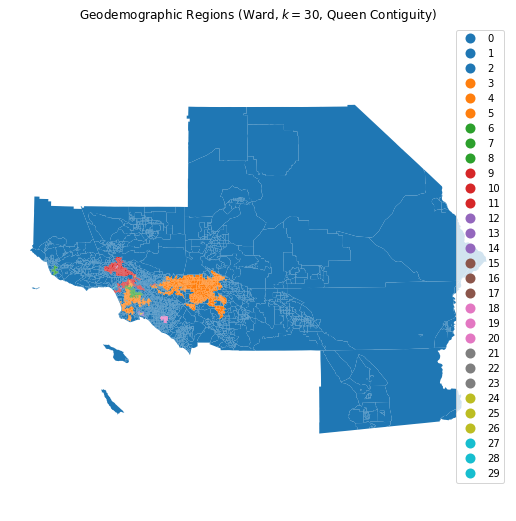

In [33]:
db['ward30wq'] = model.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including a legend and with no boundary lines
db.plot(column='ward30wq', categorical=True, legend=True, linewidth=0, ax=ax)
# Remove axis
ax.set_axis_off()
# Keep axes proportionate
plt.axis('equal')
# Add title
plt.title(r'Geodemographic Regions (Ward, $k=30$, Queen Contiguity)')
# Display the map
plt.show()

/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/pysal/lib/weights/weights.py:170: UserWarning: The weights matrix is not fully connected. There are 2 components
  warnings.warn("The weights matrix is not fully connected. There are %d components" % self.n_components)
/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/sklearn/cluster/_agglomerative.py:245: UserWarning: the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.
  affinity='euclidean')
/home/serge/anaconda3/envs/geopyter/lib/python3.7/site-packages/ipykernel_lau

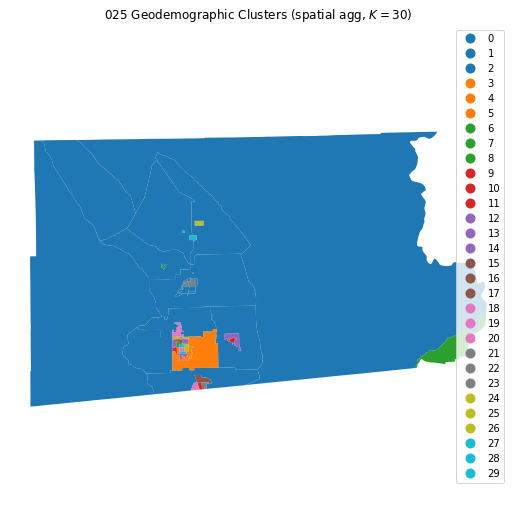

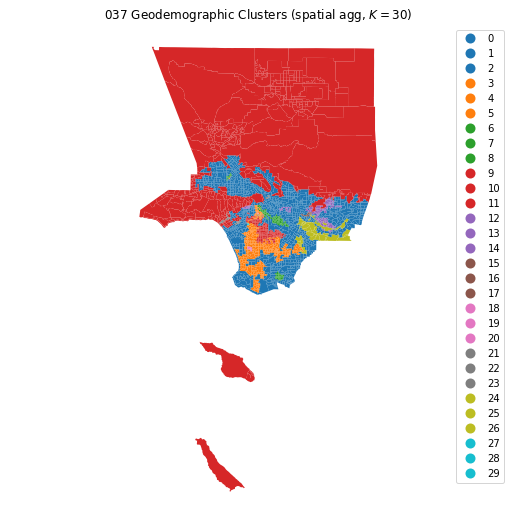

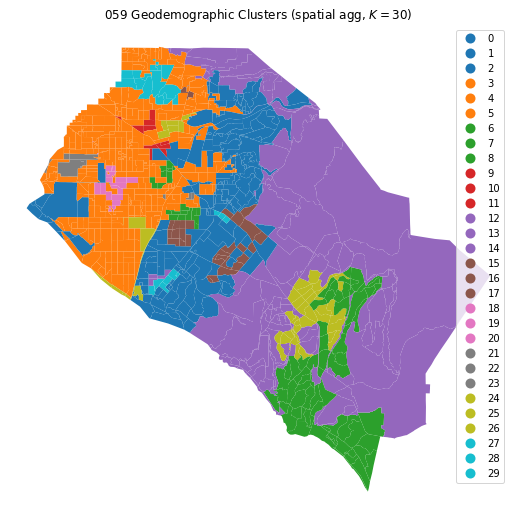

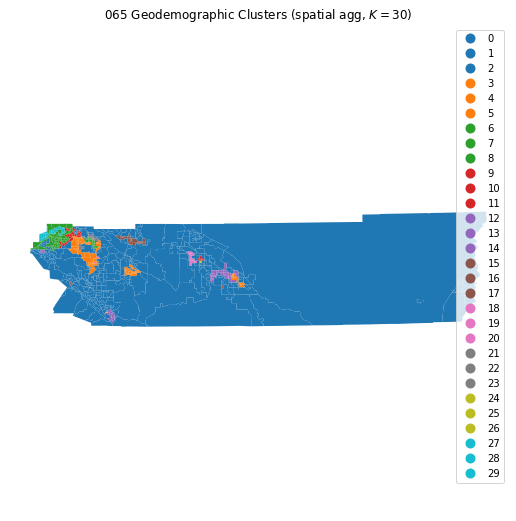

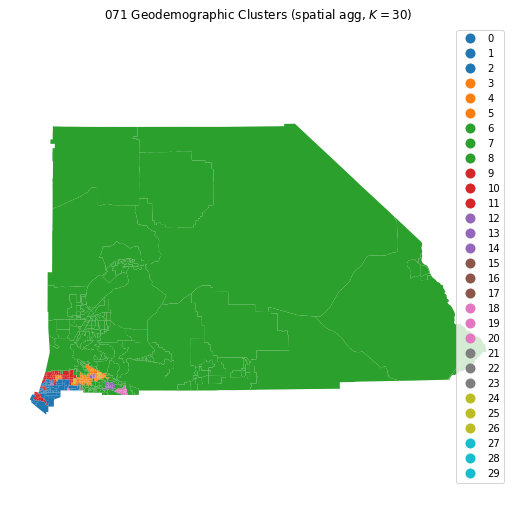

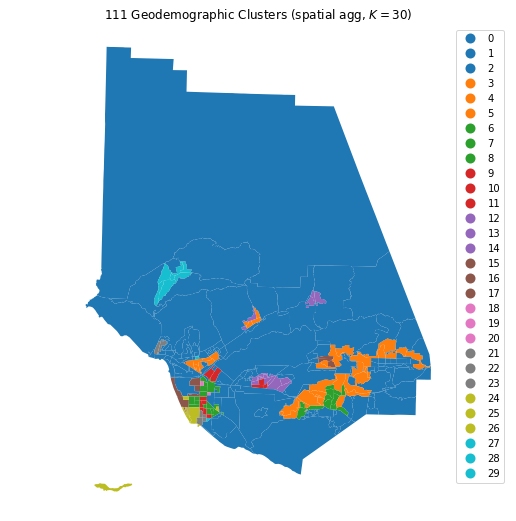

In [34]:
for county in counties:
    cdb = db[db['COUNTY']==county]
    w = Queen.from_dataframe(cdb)
    model = AgglomerativeClustering(linkage='ward',
                                            connectivity=w.sparse,
                                            n_clusters=30)
    model.fit(cdb[cluster_variables])
    cdb['ward'] = model.labels_
    f, ax = plt.subplots(1, figsize=(9, 9))
    # Plot unique values choropleth including a legend and with no boundary lines
    cdb.plot(column='ward', categorical=True, legend=True, linewidth=0, ax=ax)
    # Remove axis
    ax.set_axis_off()
    # Keep axes proportionate
    plt.axis('equal')
    # Add title
    title = f'{county} Geodemographic Clusters (spatial agg, $K=30$)'
    plt.title(title)
    # Display the map
plt.show()